<a href="https://colab.research.google.com/github/onism/MyLearning/blob/master/heart_disease_prediction_tf2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np 
import tensorflow as tf 
from tensorflow import keras       
import pandas as pd 
import seaborn as sns 
from pylab import rcParams 
import matplotlib.pyplot as plt  
from matplotlib import rc        
from sklearn.model_selection import train_test_split 

%matplotlib inline    
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42 
np.random.seed(RANDOM_SEED)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
data = pd.read_csv('datasets_33180_43520_heart.csv')
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


Text(0.5, 0, '')

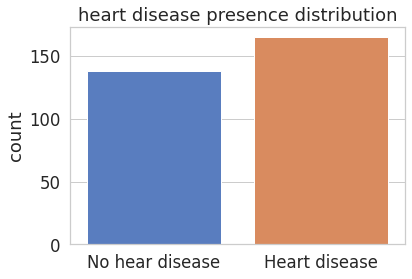

In [3]:
f = sns.countplot(x='target', data=data)
f.set_title('heart disease presence distribution')
f.set_xticklabels(['No hear disease', 'Heart disease'])
plt.xlabel('')

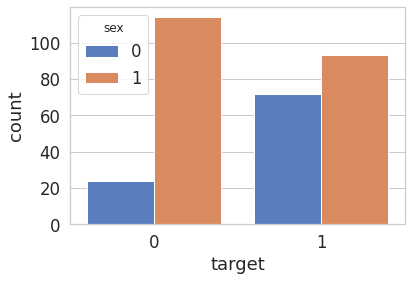

In [4]:
f = sns.countplot(x='target', data=data, hue='sex')

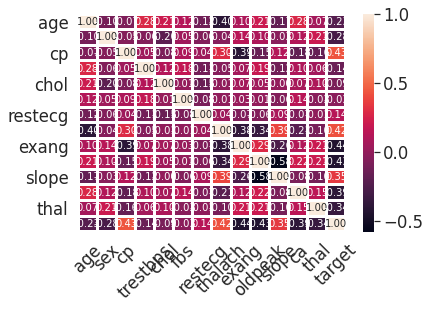

In [6]:
heat_map = sns.heatmap(data.corr(method='pearson'), annot=True, fmt='.2f', linewidths=2)
heat_map.set_xticklabels(heat_map.get_xticklabels(), rotation=45);

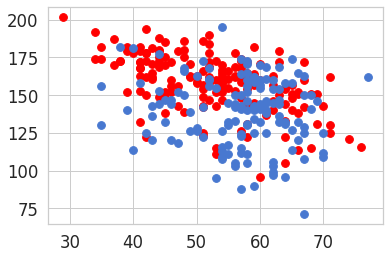

In [7]:
plt.scatter(x=data.age[(data.target==1)], y=data.thalach[(data.target ==1)], c='red', s=60)
plt.scatter(x=data.age[(data.target==0)], y=data.thalach[(data.target ==0)],   s=60)


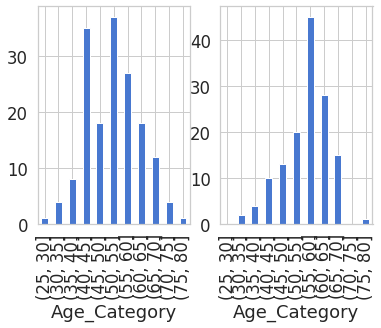

In [8]:
data['Age_Category'] = pd.cut(data['age'], bins=list( np.arange(25,85,5)  ))
plt.subplot(121)
data[data['target']==1].groupby('Age_Category')['age'].count().plot(kind='bar')
plt.subplot(122)
data[data['target']==0].groupby('Age_Category')['age'].count().plot(kind='bar')

In [9]:
feature_colums = []
for header in ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca']:
    feature_colums.append(tf.feature_column.numeric_column(header))

In [10]:
feature_colums

[NumericColumn(key='age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='trestbps', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='chol', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='thalach', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='oldpeak', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='ca', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

In [11]:
#bucketized cols
age =tf.feature_column.numeric_column('age')
age_buckets = tf.feature_column.bucketized_column(age, boundaries=[18, 25, 30, 35, 40, 45, 50, 55, 60, 65])
feature_colums.append(age_buckets)

In [12]:
data['thal'] = data['thal'].apply(str)
thal = tf.feature_column.categorical_column_with_vocabulary_list('thal', ['3', '6', '7'])

In [14]:
thal_one_hot = tf.feature_column.indicator_column(thal)
feature_colums.append(thal_one_hot)

data['sex'] = data['sex'].apply(str)
sex = tf.feature_column.categorical_column_with_vocabulary_list('sex', ['0', '1'])
sex_one_hot = tf.feature_column.indicator_column(sex)
feature_colums.append(sex_one_hot)

data['cp'] = data['cp'].apply(str)
cp = tf.feature_column.categorical_column_with_vocabulary_list('cp', ['0', '1', '2', '3'])
cp_one_hot = tf.feature_column.indicator_column(cp)
feature_colums.append(cp_one_hot)


data['slope'] = data['slope'].apply(str)
slope = tf.feature_column.categorical_column_with_vocabulary_list('slope', ['0', '1', '2'])
slope_one_hot = tf.feature_column.indicator_column(slope)
feature_colums.append(slope_one_hot)

In [15]:
# embedding cols
thal_embedding = tf.feature_column.embedding_column(thal, dimension=8)
feature_colums.append(thal_embedding)

age_thal_crossed = tf.feature_column.crossed_column([age_buckets, thal], hash_bucket_size=1000)
age_thal_crossed = tf.feature_column.indicator_column(age_thal_crossed)
feature_colums.append(age_thal_crossed)

cp_slope_crossed = tf.feature_column.crossed_column([cp, slope], hash_bucket_size=1000)
cp_slope_crossed = tf.feature_column.indicator_column(cp_slope_crossed)
feature_colums.append(cp_slope_crossed)

In [16]:
def create_dataset(dataframe, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop('target')
    return tf.data.Dataset.from_tensor_slices( (dict(dataframe), labels)).shuffle(buffer_size=len(dataframe)).batch(batch_size)

In [18]:
del data['Age_Category']

In [19]:
train, test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
train_ds = create_dataset(train)
test_ds = create_dataset(test)

In [21]:
model = tf.keras.models.Sequential([
  tf.keras.layers.DenseFeatures(feature_columns=feature_colums),
  tf.keras.layers.Dense(units=128, activation='relu'),
  tf.keras.layers.Dropout(rate=0.2),
  tf.keras.layers.Dense(units=128, activation='relu'),
  tf.keras.layers.Dense(units=1, activation='sigmoid')
])

In [23]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_ds, validation_data=test_ds, epochs=100, use_multiprocessing=True)

Epoch 1/100

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

8/8 [==============================] - 0s 58ms/step - loss: 1.5873 - accuracy: 0.5207 - val_loss: 0.6640 - val_accuracy: 0.6066
Epoch 2/100
8/8 [==============================] - 0s 6ms/step - loss: 1.0833 - accuracy: 0.6157 - val_loss: 0.5824 - val_accuracy: 0.6885
Epoch 3/100
8/8 [==============================] - 0s 6ms/step - loss: 1.0348 - accuracy: 0.5496 - val_loss: 0.6059 - val_accuracy: 0.6557
Epoch 4/100
8/8 [==============================] - 0s 6ms/step - loss: 0.9590 - accuracy: 

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_features (DenseFeature multiple                  24        
_________________________________________________________________
dense (Dense)                multiple                  260864    
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  16512     
_________________________________________________________________
dense_2 (Dense)              multiple                  129       
Total params: 277,529
Trainable params: 277,529
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.evaluate(test_ds)

2/2 [==============================] - 0s 2ms/step - loss: 0.3101 - accuracy: 0.8852


[0.31006792187690735, 0.8852459192276001]

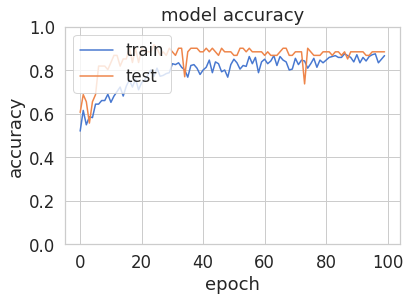

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim((0, 1))
plt.legend(['train', 'test'], loc='upper left');

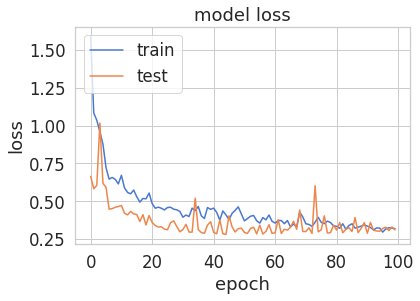

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
 


In [29]:
from sklearn.metrics import classification_report, confusion_matrix
predictions = model.predict(test_ds)

bin_predictions = tf.round(predictions).numpy().flatten()
print(classification_report(y_test.values, bin_predictions))

NameError: ignored